In [40]:
import json
import requests
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
import pandas as pd
import seaborn as sns 
import itertools
import collections
import random
import time
import urllib
pd.set_option('display.max_colwidth', None)

In [41]:
#Publicly accessible DAP collections can be accessed using /ws/v2 without authentication.
# https://data.csiro.au/dap/swagger-ui.html#/
#csiro_base_url = 'https://data.csiro.au/dap/ws/v2/collections/search'
csiro_base_url = 'https://data.csiro.au/dap/ws/v2/collections/browse/td/'

In [42]:
# FOR codes
# 05 Environmental Sciences
# 04 Earth Sciences
fields_of_research = ['Environmental Sciences','Earth Sciences', 'Agricultural and Veterinary Sciences']

Query datasets by FOR

In [43]:
test_dataset = 'https://data.csiro.au/collections/#collection/CIcsiro:13481'
test_dataset ='https://doi.org/10.4225/08/58c8f798f241a'

In [44]:
datasets = []
data_dir = 'results'
max_dataset = 500

In [45]:
# soud -> Show Only Unrestricted Data
for s in fields_of_research:
    has_next_key = False
    url = csiro_base_url+s+"/?rpp=100&sb=RELEVANCE&soud=True"
    once = True
    while True:
        try:
            r = requests.get(url, headers={'Content-Type': 'application/json'})
            response = r.json()
            if response:
                total_results = response['totalResults']
                if once == True:
                    print(s, ':', total_results)
                    once = False
                if response.get('next'):
                    next_page = response.get('next').get('href')
                    if next_page:
                        url = next_page.replace('https://data.csiro.au/dap/ws/v2/collections.json?', csiro_base_url+s+'/?')
                        print('next ', url)
                        for resp in response['dataCollections']:
                            if resp['collectionType'] =='Data' and resp['doi']:
                                datasets.append('https://doi.org/'+resp['doi'])
                else:
                    break
        except requests.exceptions.RequestException as e:
            print(e)
        except requests.exceptions.ConnectionError as e1:
            print(e1)

Environmental Sciences : 539
next  https://data.csiro.au/dap/ws/v2/collections/browse/td/Environmental Sciences/?rpp=100&sb=RELEVANCE&soud=True&p=2
next  https://data.csiro.au/dap/ws/v2/collections/browse/td/Environmental Sciences/?rpp=100&sb=RELEVANCE&soud=True&p=3
next  https://data.csiro.au/dap/ws/v2/collections/browse/td/Environmental Sciences/?rpp=100&sb=RELEVANCE&soud=True&p=4
next  https://data.csiro.au/dap/ws/v2/collections/browse/td/Environmental Sciences/?rpp=100&sb=RELEVANCE&soud=True&p=5
next  https://data.csiro.au/dap/ws/v2/collections/browse/td/Environmental Sciences/?rpp=100&sb=RELEVANCE&soud=True&p=6
Earth Sciences : 328
next  https://data.csiro.au/dap/ws/v2/collections/browse/td/Earth Sciences/?rpp=100&sb=RELEVANCE&soud=True&p=2
next  https://data.csiro.au/dap/ws/v2/collections/browse/td/Earth Sciences/?rpp=100&sb=RELEVANCE&soud=True&p=3
next  https://data.csiro.au/dap/ws/v2/collections/browse/td/Earth Sciences/?rpp=100&sb=RELEVANCE&soud=True&p=4
Agricultural and Veter

In [46]:
datasets[:3]

['https://doi.org/10.4225/08/5758CCC862AD5',
 'https://doi.org/10.25919/5f42f324b2ef8',
 'https://doi.org/10.25919/5f42f2e94119c']

In [47]:
#[item for item, count in collections.Counter(datasets).items() if count > 1]

In [48]:
print(len(datasets))
datasets = list(set(datasets))
print(len(datasets))

962
765


In [49]:
datasets = random.choices(datasets, k = max_dataset)

In [50]:
print('Total datasets :', len(datasets))

Total datasets : 500


In [51]:
testr = requests.get('https://doi.org/10.4225/08/58c8f798f241a')
if testr.history:
    print("Request was redirected")
    for res in testr.history:
        print(res.status_code, res.url)
    print("Final destination:")
    print(testr.status_code, testr.url)
else:
    print("Request was not redirected")

Request was redirected
302 https://doi.org/10.4225/08/58c8f798f241a
Final destination:
200 https://data.csiro.au/collections/#collection/CIcsiro:9973v2


Get info of all metrics implemented

In [52]:
metrics = []
try:
    request = requests.get('http://localhost:1071/fuji/api/v1/metrics',headers={'Content-Type': 'application/json'}, auth=('username', 'password'))
    mm = request.json()['metrics']
    for m in mm:
        metrics.append({k: m[k] for k in ('metric_identifier', 'metric_name', 'total_score')})
except requests.exceptions.RequestException as e:
    print(e)
except requests.exceptions.ConnectionError as e1:
    print(e1)

In [53]:
df_metrics = pd.DataFrame.from_dict(metrics)
df_metrics.head()

,metric_identifier,metric_name,total_score
0,FsF-F1-01D,Data is assigned a globally unique identifier.,1
1,FsF-F1-02D,Data is assigned a persistent identifier.,1
2,FsF-F2-01M,"Metadata includes descriptive core elements (creator, title, data identifier, publisher, publication date, summary and keywords) to support data findability.",2
3,FsF-F3-01M,Metadata includes the identifier of the data it describes.,1
4,FsF-F4-01M,Metadata is offered in such a way that it can be retrieved programmatically.,2


Run FAIR assessment for all datasets

In [54]:
%%time
fuji_service = 'http://localhost:1071/fuji/api/v1/evaluate'
all_records = []
for d in datasets:
    req = {'object_identifier':d, 'test_debug':True, 'oaipmh_endpoint':'https://data.csiro.au/oaiprovider/'}
    r = requests.post(fuji_service, data=json.dumps(req), headers={'Content-Type': 'application/json'}, auth=('username', 'password'))
    json_data = r.json()
    records = {}
    records['identifier'] = d
    records['result'] = json_data
    all_records.append(records)

Wall time: 1h 29min 3s


In [55]:
timestr = time.strftime("%Y%m%d")
timestr

'20200904'

In [56]:
file_name = data_dir+'/'+'csiro_'+timestr+'.json'
with open(file_name, 'w') as f:
    json.dump(all_records, f)

In [57]:
#file_name = 'results/csiro_20200828.json'
with open(file_name) as json_file:
    data = json.load(json_file)

In [58]:
def get_assessment_result(id):
    jsn = None
    for data_dict in data:
        if data_dict['identifier'] == id:
            jsn = data_dict['result']
    return jsn

In [59]:
get_assessment_result(test_dataset)

In [60]:
final = []
for data_dict in data:
    results = {}
    results['identifier'] = data_dict['identifier']
    dd = data_dict['result'] # list of dict
    for d in dd:
        metric_identifier = d['metric_identifier']
        sub_principle = metric_identifier.split('-')[1]
        principle = sub_principle[0]+'_earned'
        principle_total = sub_principle[0]+'_total'
        if not sub_principle in results:
            results[sub_principle] = d['score']['earned']
        else:
            results[sub_principle] += d['score']['earned']
        if not principle in results:
            results[principle] = d['score']['earned']
        else:
            results[principle] += d['score']['earned']
        if not principle_total in results:
            results[principle_total] = d['score']['total']
        else:
            results[principle_total] += d['score']['total']
    final.append(results)

In [61]:
df_results = pd.DataFrame.from_dict(final)

In [62]:
cols = ['identifier','F1','F2','F3','F4','A1','A1','I1','I3','R1','R1.1','R1.2','R1.3','F_earned','F_total','A_earned','A_total','I_earned','I_total','R_earned','R_total']
df_results = df_results[cols]

In [63]:
df_results.head()

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,R1.2,R1.3,F_earned,F_total,A_earned,A_total,I_earned,I_total,R_earned,R_total
0,https://doi.org/10.4225/08/5726ED34D9CD1,2,1,0,2,0,0,1,0,1,...,1,1,5,7,0,1,1,4,3,9
1,https://doi.org/10.25919/5f0d269162071,2,1,0,2,0,0,1,0,1,...,1,1,5,7,0,1,1,4,3,9
2,https://doi.org/10.25919/5dce308ed7efe,2,1,0,2,0,0,1,0,1,...,1,1,5,7,0,1,1,4,3,9
3,https://doi.org/10.4225/08/5587A7FB8006B,2,1,0,2,0,0,1,0,1,...,1,1,5,7,0,1,1,4,3,9
4,https://doi.org/10.25919/5f081ccf14339,2,1,0,2,0,0,1,1,1,...,1,1,5,7,0,1,2,4,3,9


In [64]:
df_results ['F_Principle'] = (df_results ['F_earned'] / df_results ['F_total'] ).round(2)
df_results ['A_Principle'] = (df_results ['A_earned'] / df_results ['A_total'] ).round(2)
df_results ['I_Principle'] = (df_results ['I_earned'] / df_results ['I_total'] ).round(2)
df_results ['R_Principle' ]= (df_results ['R_earned'] / df_results ['R_total'] ).round(2)

In [65]:
df_results.head()

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,A_earned,A_total,I_earned,I_total,R_earned,R_total,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.4225/08/5726ED34D9CD1,2,1,0,2,0,0,1,0,1,...,0,1,1,4,3,9,0.71,0.0,0.25,0.33
1,https://doi.org/10.25919/5f0d269162071,2,1,0,2,0,0,1,0,1,...,0,1,1,4,3,9,0.71,0.0,0.25,0.33
2,https://doi.org/10.25919/5dce308ed7efe,2,1,0,2,0,0,1,0,1,...,0,1,1,4,3,9,0.71,0.0,0.25,0.33
3,https://doi.org/10.4225/08/5587A7FB8006B,2,1,0,2,0,0,1,0,1,...,0,1,1,4,3,9,0.71,0.0,0.25,0.33
4,https://doi.org/10.25919/5f081ccf14339,2,1,0,2,0,0,1,1,1,...,0,1,2,4,3,9,0.71,0.0,0.50,0.33


In [66]:
df_results[df_results.identifier ==test_dataset]

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,A_earned,A_total,I_earned,I_total,R_earned,R_total,F_Principle,A_Principle,I_Principle,R_Principle


In [67]:
df_hist = df_results[['identifier','F_Principle','A_Principle','I_Principle','R_Principle']]
df_hist

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.4225/08/5726ED34D9CD1,0.71,0.0,0.25,0.33
1,https://doi.org/10.25919/5f0d269162071,0.71,0.0,0.25,0.33
2,https://doi.org/10.25919/5dce308ed7efe,0.71,0.0,0.25,0.33
3,https://doi.org/10.4225/08/5587A7FB8006B,0.71,0.0,0.25,0.33
4,https://doi.org/10.25919/5f081ccf14339,0.71,0.0,0.50,0.33
...,...,...,...,...,...
495,https://doi.org/10.4225/08/5afaad925cbfa,0.71,0.0,0.25,0.33
496,https://doi.org/10.4225/08/579AA85D210E7,0.71,0.0,0.50,0.33
497,https://doi.org/10.4225/08/5726ED34D9CD1,0.71,0.0,0.25,0.33
498,https://doi.org/10.4225/08/5a559030971cb,0.71,0.0,0.50,0.33


In [68]:
timestr

'20200904'

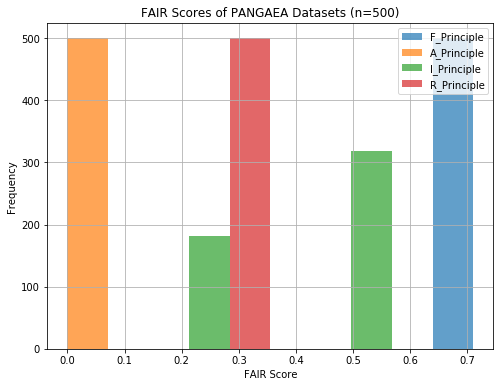

In [69]:
title = "FAIR Scores of PANGAEA Datasets (n="+str(len(df_hist))+")"
df_hist.plot.hist(sharex=True,sharey=True,alpha=0.7,figsize = (8,6), title=title)
plt.xlabel('FAIR Score')
fig_name = data_dir+'/'+'pangaea_'+timestr+'.png'
plt.savefig(fig_name)

In [70]:
principles = {}
principles['F_Principle'] = 'Findability'
principles['A_Principle'] = 'Accessibility'
principles['I_Principle'] = 'Interoperability'
principles['R_Principle'] = 'Reusability'
def histograms_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,4))
    # set palette 
    palette = itertools.cycle(sns.color_palette())
    for i, feature in enumerate(features):
        c = next(palette)
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].plot.hist(bins=20, ax=ax, color=c, range=(0, 1.0))
        ax.set_title(principles.get(feature))
        ax.set(xlabel="Score", ylabel="Frequency")
    #fig.tight_layout()  
    fig_name = data_dir+'/'+'sub_csiro_'+timestr+'.png'
    fig.subplots_adjust(top=0.8)
    plt.savefig(fig_name)
    plt.suptitle('FAIR Scores of CSIRO Datasets By Principle '+ ' (n=' + str(len(df_hist))+')',fontsize=15)
    plt.show()

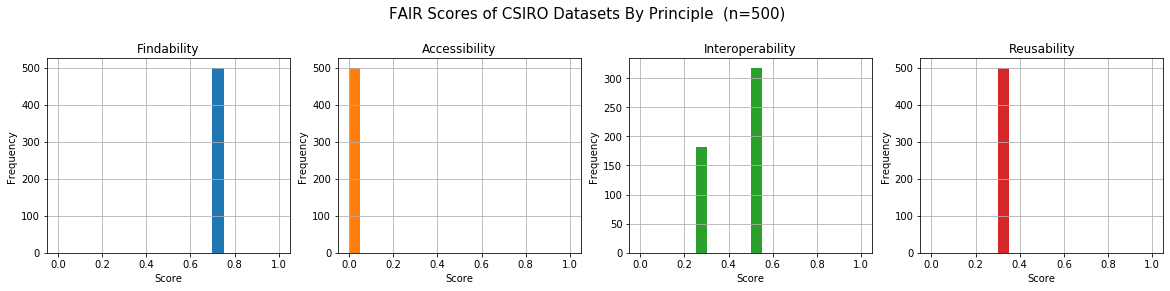

In [71]:
histograms_plot(df_hist,df_hist.columns[1:],1,4)

Inspect FINDABILITY 

In [72]:
#Missing core metadata ['keywords']" - seems like keywords are not sent to datacite service as part of the registration
# Data (content) identifier is missing
df_hist[df_hist.F_Principle <0.8]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.4225/08/5726ED34D9CD1,0.71,0.0,0.25,0.33
1,https://doi.org/10.25919/5f0d269162071,0.71,0.0,0.25,0.33
2,https://doi.org/10.25919/5dce308ed7efe,0.71,0.0,0.25,0.33
3,https://doi.org/10.4225/08/5587A7FB8006B,0.71,0.0,0.25,0.33
4,https://doi.org/10.25919/5f081ccf14339,0.71,0.0,0.50,0.33
...,...,...,...,...,...
495,https://doi.org/10.4225/08/5afaad925cbfa,0.71,0.0,0.25,0.33
496,https://doi.org/10.4225/08/579AA85D210E7,0.71,0.0,0.50,0.33
497,https://doi.org/10.4225/08/5726ED34D9CD1,0.71,0.0,0.25,0.33
498,https://doi.org/10.4225/08/5a559030971cb,0.71,0.0,0.50,0.33


Inspect ACCESSBILITY

In [73]:
df_hist[df_hist.A_Principle <0.8].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.4225/08/5726ED34D9CD1,0.71,0.0,0.25,0.33
1,https://doi.org/10.25919/5f0d269162071,0.71,0.0,0.25,0.33
2,https://doi.org/10.25919/5dce308ed7efe,0.71,0.0,0.25,0.33
3,https://doi.org/10.4225/08/5587A7FB8006B,0.71,0.0,0.25,0.33
4,https://doi.org/10.25919/5f081ccf14339,0.71,0.0,0.50,0.33


In [74]:
#For normal collections these should be accurate, e.g. accessLevel will be something like:
#•	Public
#•	CSIRO Users Only
#•	Specific Users
df_hist[df_hist.A_Principle > 0.8]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle


Inspect INTEROPERABILITY

In [75]:
#NO RDF metadata available (sparql, content-negotiation)
#Total number of related resources extracted - 0
df_hist[df_hist.I_Principle < 0.3]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.4225/08/5726ED34D9CD1,0.71,0.0,0.25,0.33
1,https://doi.org/10.25919/5f0d269162071,0.71,0.0,0.25,0.33
2,https://doi.org/10.25919/5dce308ed7efe,0.71,0.0,0.25,0.33
3,https://doi.org/10.4225/08/5587A7FB8006B,0.71,0.0,0.25,0.33
9,https://doi.org/10.4225/08/576E043172C7D,0.71,0.0,0.25,0.33
...,...,...,...,...,...
490,https://doi.org/10.4225/08/5afab56a81df5,0.71,0.0,0.25,0.33
491,https://doi.org/10.25919/5f294c6caee97,0.71,0.0,0.25,0.33
494,https://doi.org/10.4225/08/5b2f074ebc1af,0.71,0.0,0.25,0.33
495,https://doi.org/10.4225/08/5afaad925cbfa,0.71,0.0,0.25,0.33


In [76]:
##NO RDF metadata available (sparql, content-negotiation)
df_hist[df_hist.I_Principle > 0.3] 

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
4,https://doi.org/10.25919/5f081ccf14339,0.71,0.0,0.5,0.33
5,https://doi.org/10.4225/08/54C96117894C4,0.71,0.0,0.5,0.33
6,https://doi.org/10.25919/5b8f30751cd38,0.71,0.0,0.5,0.33
7,https://doi.org/10.25919/5ba9d1c805949,0.71,0.0,0.5,0.33
8,https://doi.org/10.4225/08/53EC5BA344FD4,0.71,0.0,0.5,0.33
...,...,...,...,...,...
492,https://doi.org/10.4225/08/5486972769F2F,0.71,0.0,0.5,0.33
493,https://doi.org/10.25919/5eaadae091d8f,0.71,0.0,0.5,0.33
496,https://doi.org/10.4225/08/579AA85D210E7,0.71,0.0,0.5,0.33
498,https://doi.org/10.4225/08/5a559030971cb,0.71,0.0,0.5,0.33


Inspect REUSABILITY

In [77]:
#"INFO: Resource type specified - Dataset",
# "WARNING: NO object content available to perform file descriptors (type and size) tests",
# "WARNING: NO measured variables found in metadata, skip 'measured_variable' test.
# "WARNING: NO license information is included in metadata"

#structured_provenance_unavailable
#Could not perform file format checks, no object content identifiers available
df_hist[df_hist.R_Principle < 0.5] 

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.4225/08/5726ED34D9CD1,0.71,0.0,0.25,0.33
1,https://doi.org/10.25919/5f0d269162071,0.71,0.0,0.25,0.33
2,https://doi.org/10.25919/5dce308ed7efe,0.71,0.0,0.25,0.33
3,https://doi.org/10.4225/08/5587A7FB8006B,0.71,0.0,0.25,0.33
4,https://doi.org/10.25919/5f081ccf14339,0.71,0.0,0.50,0.33
...,...,...,...,...,...
495,https://doi.org/10.4225/08/5afaad925cbfa,0.71,0.0,0.25,0.33
496,https://doi.org/10.4225/08/579AA85D210E7,0.71,0.0,0.50,0.33
497,https://doi.org/10.4225/08/5726ED34D9CD1,0.71,0.0,0.25,0.33
498,https://doi.org/10.4225/08/5a559030971cb,0.71,0.0,0.50,0.33
